## Assignment 2 - Credit Card Fraud Detection Feature Engineering

In [66]:
# Generate the data
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd
import seaborn as sns
import plotly
import plotly.express as px
import scipy.stats as stats
import plotly.io as pio
pio.renderers.default = "notebook"

In [203]:
df = pd.read_csv('purchase_credit_card.csv')
df.head(5)

,Year-Month,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Description,Amount,Vendor,Transaction Date,Posted Date,Merchant Category Code (MCC)
0,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS
1,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,SHERATON
2,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,GENERAL PURCHASE,165.82,SEARS.COM 9300,07/29/2013 12:00:00 AM,07/31/2013 12:00:00 AM,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...
3,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,GENERAL PURCHASE,96.39,WAL-MART #0137,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,"GROCERY STORES,AND SUPERMARKETS"
4,201307,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,HAMMERMILL COPY PLUS COPY EA,125.96,STAPLES DIRECT,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRIT..."


In [5]:
# check dimensions of the dataset, we found it has 442,458 rows and 11 columns 
print(df.shape)
print(df.columns) # check column names
df.describe() # Get the Simple Summary Statistics 

(442458, 11)
Index(['Year_Month', 'Agency_Number', 'Agency_Name', 'Cardholder_Last_Name',
       'Cardholder_First_Initial', 'Description', 'Amount', 'Vendor',
       'Transaction_Date', 'Posted_Date', 'Merchant_Category'],
      dtype='object')


,Year_Month,Agency_Number,Amount
count,442458.000000,442458.000000,4.424580e+05
mean,201357.284375,42785.860353,4.249912e+02
std,47.107417,33378.461293,5.266509e+03
min,201307.000000,1000.000000,-4.286304e+04
25%,201309.000000,1000.000000,3.091000e+01
50%,201401.000000,47700.000000,1.048900e+02
75%,201404.000000,76000.000000,3.450000e+02
max,201406.000000,98000.000000,1.903858e+06


In [6]:
# change column names 
df.columns = ['Year_Month', 'Agency_Number', 'Agency_Name', 'Cardholder_Last_Name',
      'Cardholder_First_Initial', 'Description', 'Amount', 'Vendor', 'Transaction_Date',
      'Posted_Date', 'Merchant_Category']

## 1. Transform the data format

### 1.1 Date Field

In [7]:
#Creating separate Year and Month columns for future feature engineering
#Converting Transaction_Date and Posted_date from Python Object data type to datetime
df['Transaction_Date']=pd.to_datetime(df['Transaction_Date']) #the detail time are all at 12 am so no need to transform the detail time
df['Posted_Date']=pd.to_datetime(df['Posted_Date'])

#Convert Year_Month to date format
df['Year_Month'].dtype
df['Year_Month']=pd.to_datetime(df['Year_Month'], format='%Y%m')
df['Year'] = df['Year_Month'].dt.year
df['Month'] = df['Year_Month'].dt.month

#Creating 'Week_Number' from 'Transaction_Date'
df['Week_Number'] = df['Transaction_Date'].dt.isocalendar().week


#Creating 'Day_of_Week' from 'Transaction_Date'
day0fWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
df['Day_of_Week'] = df['Transaction_Date'].dt.dayofweek.map(day0fWeek)

df['Day_of_Week'].value_counts()

Wednesday    89644
Thursday     87537
Tuesday      86919
Friday       79917
Monday       61809
Saturday     26307
Sunday       10325
Name: Day_of_Week, dtype: int64

## 2. Initial observations

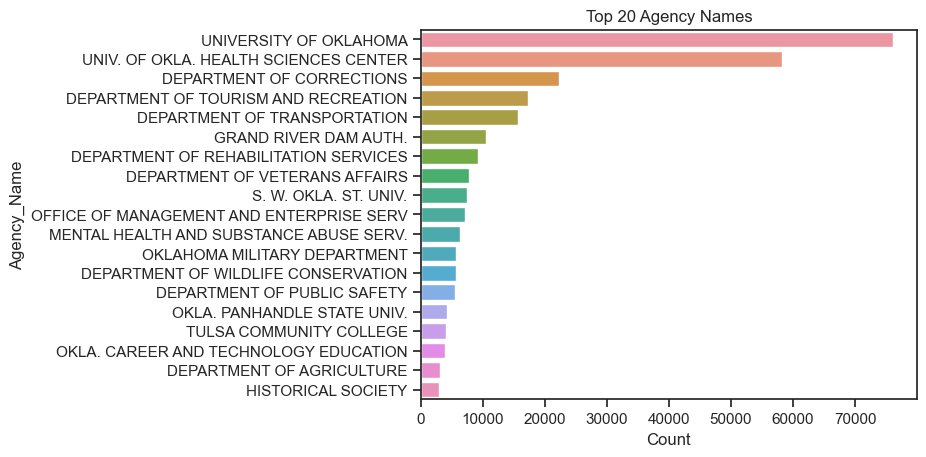

In [8]:
# Summarize the count statistics by agency_name in df_count
df_count = df['Agency_Name'].value_counts()
df_count = pd.DataFrame(df_count).reset_index()
df_count.columns = ['Agency_Name','Count']

fig = px.bar(df_count, x='Agency_Name', y='Count', color = 'Agency_Name', width=1000, height=400)

sns.set_theme(style="ticks")
sns.barplot(y="Agency_Name", x="Count", data=df_count[1:20]).set_title('Top 20 Agency Names')
plt.show()

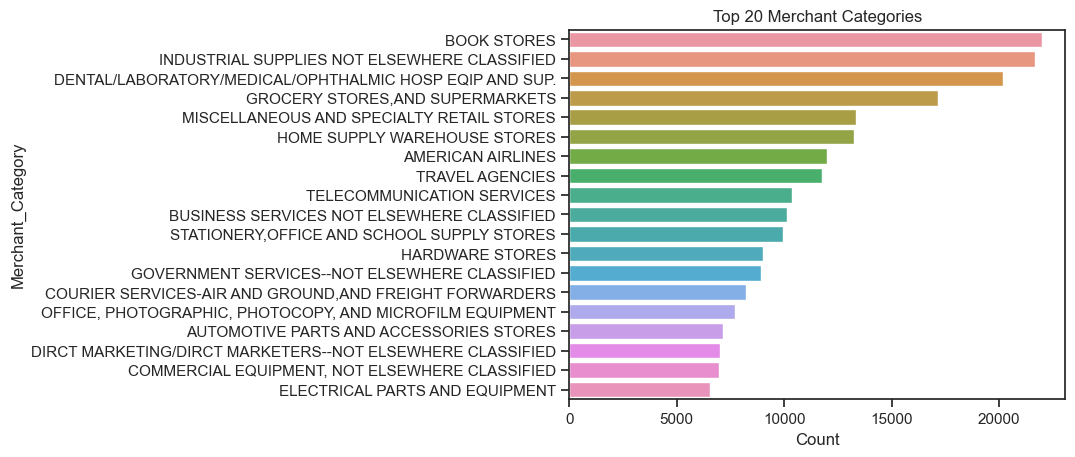

In [9]:
# Summarize the count statistics by Merchant_Category in df_count
df_count = df['Merchant_Category'].value_counts()
df_count = pd.DataFrame(df_count).reset_index()
df_count.columns = ['Merchant_Category','Count']

fig = px.bar(df_count, x='Merchant_Category', y='Count', color = 'Merchant_Category', width=1000, height=400)

sns.set_theme(style="ticks")
sns.barplot(y="Merchant_Category", x="Count", data=df_count[1:20]).set_title('Top 20 Merchant Categories')
plt.show()

## 3. Feature Engineering
The feature engineering could be listed as three kinds of methods; likewise, there are monetary, frequency, and recency approaches. In this case, I adopt more monetary features comparing to frequency and recency features since the dataset has insufficient number of transactions and detailed transaction time data. Also, because of the dataset only contains one year record of transaction so that the features are mainly on a weekly or monthly basis. 

###  3.1a Monetary Feature 1: The ratio to average spending amount grouped by Agency and Merchant Category
Monetary feature is a more straightforward dimension to detect the anomalies from the amount that significantly deviates the average spending. The outliers can be detected if the transaction amount deviates the average spending from same agency and merchant category too much. Here the benchmark is the average spending ratio = 2.

In [10]:
# create average spending group by agency and merchant category 
stat_by_agency = df.groupby(['Agency_Name', 'Merchant_Category'])['Amount'].mean()
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['AVG_amount']
stat_by_agency

AVG_amount
Agency_Name                     Merchant_Category                                     
ARDMORE HIGHER EDUCATION CENTER BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED  115.120000
                                CATALOG MERCHANTS                           -53.344286
                                COMPUTER NETWORK/INFORMATION SERVICES        18.340000
                                DRUG STORES AND PHARMACIES                  153.450000
                                GROCERY STORES,AND SUPERMARKETS              74.525455
...                                                                                ...
`DEPARTMENT OF EDUCATION        TELECOMMUNICATION SERVICES                  118.054000
                                TRAVEL AGENCIES                              24.253731
                                TROPICANA RESORT AND CASINO                 481.600000
                                UNITED AIRLINES                             310.547368
                                WYNDHAM HOTELS                               93.282857

[8427 rows x 1 columns]

In [11]:
# add the new feature average spending to the dataset 
df1 = pd.merge(df, stat_by_agency, how='left', on=['Agency_Name', 'Merchant_Category'])
# Feature 1: ratio of amount spending and avergae spending by merchant category 
df1['agency_merchant_avg_ratio_amount'] = np.where(df1['AVG_amount']==0,0, df1['Amount'] / df1['AVG_amount'])
df1['agency_merchant_avg_ratio_amount'].describe()

count    442458.000000
mean          0.999724
std           7.225363
min       -2735.680000
25%           0.177145
50%           0.515301
75%           1.102916
max        2735.680000
Name: agency_merchant_avg_ratio_amount, dtype: float64

In [12]:
#The values spread into a wide range
#cut by percentile for plotting
var = 'agency_merchant_avg_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df1[binned_var] = pd.qcut(df1[var],percentile)
df1[['agency_merchant_avg_ratio_amount_D']]

,agency_merchant_avg_ratio_amount_D
0,"(1.298, 3.515]"
1,"(0.515, 1.298]"
2,"(0.133, 0.515]"
3,"(1.298, 3.515]"
4,"(0.133, 0.515]"
...,...
442453,"(0.515, 1.298]"
442454,"(0.133, 0.515]"
442455,"(0.0212, 0.133]"
442456,"(8.71, 2735.68]"


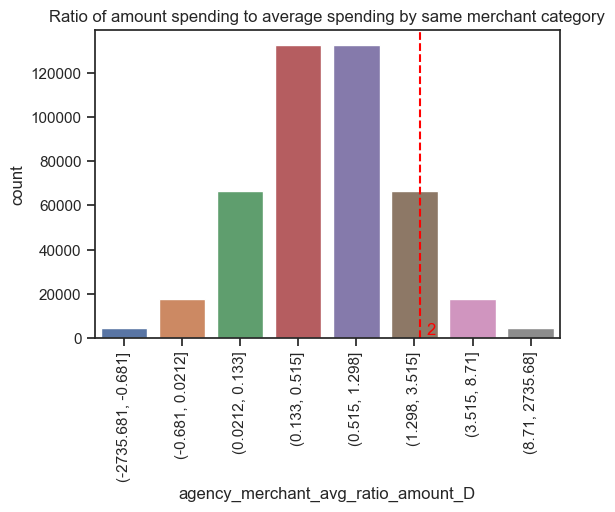

In [13]:
#Plot the histogram of ratio of amount spending and average spending by merchant category in percentile
plt.figure(figsize=(6,4))
g = sns.countplot(x="agency_merchant_avg_ratio_amount_D", data=df1)

g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Ratio of amount spending to average spending by same merchant category')

plt.axvline(x=5.1, color='red', linestyle='--')
plt.text(5.2, 0.9, '2', color='red', fontsize=12, verticalalignment='bottom')
plt.show()

The chart displays in a bell shape of normal distribution but to identify the anomalies, I set up the spending ratio benchmark as 2 and compare it to the same merchant category.

In [14]:
df1[df1['agency_merchant_avg_ratio_amount']>2].sort_values('agency_merchant_avg_ratio_amount', ascending=False).head()

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Day_of_Week,AVG_amount,agency_merchant_avg_ratio_amount,agency_merchant_avg_ratio_amount_D
147691,2013-08-01,63500,COMM. ON CONSUMER CREDIT,Todd,E,ROOM CHARGES,512.94,SHERATON DENVER,2013-08-07,2013-08-08,SHERATON,2013,8,32,Wednesday,0.187500,2735.680000,"(8.71, 2735.68]"
147648,2013-07-01,63500,COMM. ON CONSUMER CREDIT,Willson,M,ROOM CHARGES,170.98,SHERATON DENVER,2013-07-17,2013-07-18,SHERATON,2013,7,29,Wednesday,0.187500,911.893333,"(8.71, 2735.68]"
147634,2013-07-01,63500,COMM. ON CONSUMER CREDIT,Willson,M,ROOM CHARGES,170.98,SHERATON DENVER,2013-07-18,2013-07-19,SHERATON,2013,7,29,Thursday,0.187500,911.893333,"(8.71, 2735.68]"
147645,2013-07-01,63500,COMM. ON CONSUMER CREDIT,Willson,M,ROOM CHARGES,170.98,SHERATON DENVER,2013-07-17,2013-07-18,SHERATON,2013,7,29,Wednesday,0.187500,911.893333,"(8.71, 2735.68]"
285032,2014-02-01,2500,OKLAHOMA MILITARY DEPARTMENT,MCCALL,L,GENERAL PURCHASE,43296.00,SUNSHINE INDUSTRIES INC,2014-02-24,2014-02-25,"STATIONERY,OFFICE AND SCHOOL SUPPLY STORES",2014,2,9,Monday,149.098537,290.385144,"(8.71, 2735.68]"


###  3.1b Monetary Feature 2: The ratio to median spending amount grouped by Agency and Merchant Category
The outliers can be detected if the transaction amount deviates the median spending from same agency and merchant category too much. Here the benchmark is the median spending ratio = 2.

In [15]:
# create average spending group by agency and merchant category 
stat_by_agency = df.groupby(['Agency_Name', 'Merchant_Category'])['Amount'].median() 
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['Median_amount']

#### Merge the data

In [16]:
# add the new feature median spending to the dataset 
df2 = pd.merge(df, stat_by_agency, how='left', on=['Agency_Name', 'Merchant_Category'])
 
df2['agency_merchant_median_ratio_amount'] = np.where(df2['Median_amount']==0,0, df2['Amount'] / df2['Median_amount'])
df2['agency_merchant_median_ratio_amount'].describe()

count    442458.000000
mean          4.952685
std        1078.581350
min       -1003.176471
25%           0.466090
50%           1.000000
75%           2.121102
max      528116.052705
Name: agency_merchant_median_ratio_amount, dtype: float64

#### Cut the ratio into binned percentile values 

In [17]:
#The values spread into a wide range
#cut by percentile for plotting
var = 'agency_merchant_median_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df2[binned_var] = pd.qcut(df2[var],percentile)
df2[['agency_merchant_median_ratio_amount_D']]

,agency_merchant_median_ratio_amount_D
0,"(2.691, 9.283]"
1,"(1.0, 2.691]"
2,"(0.362, 1.0]"
3,"(2.691, 9.283]"
4,"(1.0, 2.691]"
...,...
442453,"(1.0, 2.691]"
442454,"(2.691, 9.283]"
442455,"(0.362, 1.0]"
442456,"(28.085, 528116.053]"


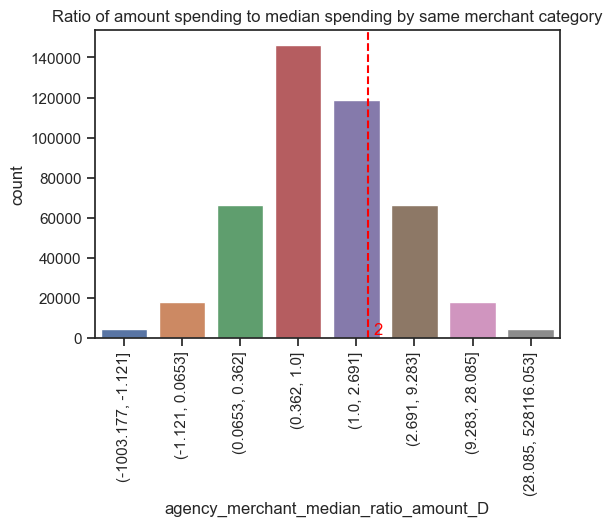

In [18]:
#Plot the histogram of ratio of amount spending and median spending by merchant category in percentile
plt.figure(figsize=(6,4))
g = sns.countplot(x="agency_merchant_median_ratio_amount_D", data=df2)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Ratio of amount spending to median spending by same merchant category')

plt.axvline(x=4.2, color='red', linestyle='--')
plt.text(4.3, 0.9, '2', color='red', fontsize=12, verticalalignment='bottom')
plt.show()

The median chart shows right-skewed distribution which means the mean ratio is greater than the median ratio.

In [19]:
df2[df2['agency_merchant_median_ratio_amount']>2].sort_values('agency_merchant_median_ratio_amount', ascending=False).head()

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Day_of_Week,Median_amount,agency_merchant_median_ratio_amount,agency_merchant_median_ratio_amount_D
218925,2013-09-01,77000,UNIV. OF OKLA. HEALTH SCIENCES CENTER,77000,7,GENERAL PURCHASE,1903858.37,PAYMENT ADJUSTMENT,2013-08-21,2013-09-12,OTHER FEES,2013,9,34,Wednesday,3.605,528116.052705,"(28.085, 528116.053]"
212076,2013-08-01,77000,UNIV. OF OKLA. HEALTH SCIENCES CENTER,77000,7,GENERAL PURCHASE,1750379.98,PAYMENT ADJUSTMENT,2013-07-19,2013-08-05,OTHER FEES,2013,8,29,Friday,3.605,485542.296810,"(28.085, 528116.053]"
400124,2014-05-01,34500,DEPARTMENT OF TRANSPORTATION,Johnson,C,SALT PRODUCTS NMB,348053.75,NORTH AMERICAN SALT CO,2014-05-12,2014-05-13,CHEMICALS AND ALLIED PRODUCTS NOT ELSEWHERE CL...,2014,5,20,Monday,122.560,2839.864148,"(28.085, 528116.053]"
303482,2014-03-01,34500,DEPARTMENT OF TRANSPORTATION,Johnson,C,SALT PRODUCTS NMB,227438.75,NORTH AMERICAN SALT CO,2014-03-25,2014-03-26,CHEMICALS AND ALLIED PRODUCTS NOT ELSEWHERE CL...,2014,3,13,Tuesday,122.560,1855.733926,"(28.085, 528116.053]"
251488,2013-10-01,98000,GRAND RIVER DAM AUTH.,Cardholder,e,GENERAL PURCHASE,814934.76,EMC CORPORATION,2013-10-03,2013-10-07,"COMPUTERS, COMPUTER PERIPHERAL EQUIPMENT, SOFT...",2013,10,40,Thursday,468.990,1737.637817,"(28.085, 528116.053]"


###  3.1c Monetary Feature 3: The ratio to average amount grouped by Agency, Merchant Category, and Month
The outliers can be detected if the transaction amount greatly deviates the average monthly spending from same agency, merchant category, and month. Here the benchmark is the average spending ratio = 2.

In [20]:
# create average monthly spending group by agency and merchant category
stat_by_agency = df.groupby(['Agency_Name', 'Merchant_Category', 'Month'])['Amount'].mean() 
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['AVG_amount']
stat_by_agency.head

<bound method NDFrame.head of                                                                                   AVG_amount
Agency_Name                     Merchant_Category                          Month            
ARDMORE HIGHER EDUCATION CENTER BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED 11     115.120000
                                CATALOG MERCHANTS                          7     -637.750000
                                                                           8      669.080000
                                                                           9     -334.540000
                                                                           10     334.540000
...                                                                                      ...
`DEPARTMENT OF EDUCATION        UNITED AIRLINES                            9      260.450000
                                                                           10     523.800000
                                        

#### Merge the data
Left join the average amount to the original data frame and calculate the ratio of spending amount and average amount

In [21]:
# add the new feature average monthly spending to the dataset 
df3 = pd.merge(df, stat_by_agency, how='left', on=['Agency_Name', 'Merchant_Category', 'Month'])
 
df3['agency_merchant_month_avg_ratio_amount'] = np.where(df3['AVG_amount']==0,0, df3['Amount'] / df3['AVG_amount'])
df3['agency_merchant_month_avg_ratio_amount'].describe()

count    4.424580e+05
mean     9.991488e-01
std      5.961952e+13
min     -2.447706e+16
25%      2.017647e-01
50%      5.984763e-01
75%      1.125213e+00
max      3.059633e+16
Name: agency_merchant_month_avg_ratio_amount, dtype: float64

#### Cut the ratio into binned percentile values 
Since the values above have spreaded into a wide range, it would be easy to cut them into binned values for the plotting

In [22]:
#The values spread into a wide range
#cut by percentile for plotting
var = 'agency_merchant_month_avg_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df3[binned_var] = pd.qcut(df3[var],percentile)
df3[['agency_merchant_month_avg_ratio_amount_D']]

,agency_merchant_month_avg_ratio_amount_D
0,"(1.34, 3.417]"
1,"(0.598, 1.34]"
2,"(0.151, 0.598]"
3,"(1.34, 3.417]"
4,"(0.151, 0.598]"
...,...
442453,"(0.151, 0.598]"
442454,"(0.151, 0.598]"
442455,"(0.0239, 0.151]"
442456,"(8.05, 3.0596329968448308e+16]"


#### Plot the histogram of percentile
The chart shows a normal distribution with mean and median ratios are close to each other.

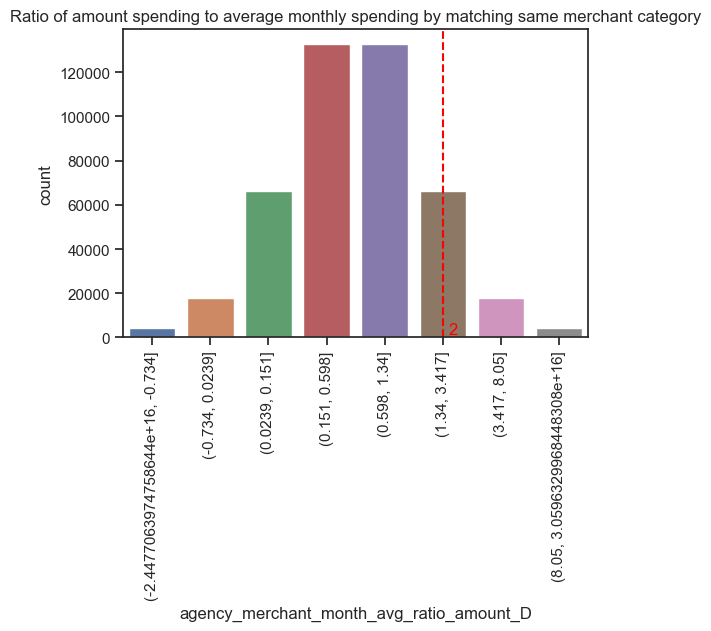

In [23]:
#Plot the histogram of ratio of amount spending and median monthly spending by merchant category in percentile
plt.figure(figsize=(6,4))
g = sns.countplot(x="agency_merchant_month_avg_ratio_amount_D", data=df3)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Ratio of amount spending to average monthly spending by matching same merchant category')

plt.axvline(x=5, color='red', linestyle='--')
plt.text(5.1, 0.9, '2', color='red', fontsize=12, verticalalignment='bottom')
plt.show()

There are over 50k number of transactions are deemed as outliers here.

In [24]:
df3[df3['agency_merchant_month_avg_ratio_amount']>2].head()

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Day_of_Week,AVG_amount,agency_merchant_month_avg_ratio_amount,agency_merchant_month_avg_ratio_amount_D
16,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mohiuddin,I,GENERAL PURCHASE,2425.0,WESTERN EQUIPMENT ALVA,2013-07-29,2013-07-31,HARDWARE STORES,2013,7,31,Monday,235.679053,10.289417,"(8.05, 3.0596329968448308e+16]"
17,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mohiuddin,I,GENERAL PURCHASE,2425.0,WESTERN EQUIPMENT ALVA,2013-07-29,2013-07-31,HARDWARE STORES,2013,7,31,Monday,235.679053,10.289417,"(8.05, 3.0596329968448308e+16]"
33,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Gerlt,T,GENERAL PURCHASE,3582.0,TELVENT,2013-07-26,2013-07-29,BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED,2013,7,30,Friday,568.982548,6.295448,"(3.417, 8.05]"
47,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,DALCOUR,K,GENERAL PURCHASE,1312.2,NATURAL WATER COMPANY LLC,2013-07-24,2013-07-26,BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED,2013,7,30,Wednesday,568.982548,2.306222,"(1.34, 3.417]"
49,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,DALCOUR,K,GENERAL PURCHASE,914.0,AUTO-CHLOR SERVICES INC,2013-07-24,2013-07-26,CATALOG MERCHANTS,2013,7,30,Wednesday,450.829655,2.027373,"(1.34, 3.417]"


#### Conclusion
As the anomaly benchmark is set as the average ratio that is greater than 2. The data above shows the anomalies that are detected from the average ratio in the agency_merchant_month_avg_ratio_amount column. Noticeably, the first 2 rows of data are suspicious transactions because they show 10 times greater than the average ratio and which are repeat transactions in the same merchant category at the same day with the same amount on the same cardholder. However, there might be another potential reason to explain this phenomenon which the cardholder abuses the corporate card. The following two rows of data are suspicious but unlike the first 2 rows due to these 2 transactions could be made through different cardholders on different dates.

###  3.1d Monetary Feature 4: The ratio of amount spending to median monthly amount grouped by Agency and Merchant Category
The outliers can be detected if the transaction amount greatly deviates the median monthly spending from same agency, merchant category, and month. Here the benchmark is the median spending ratio = 2.

In [25]:
# create median monthly spending group by agency, merchant category
stat_by_mon4 = df.groupby(['Agency_Name', 'Merchant_Category', 'Month'])['Amount'].median() 
stat_by_mon4 = pd.DataFrame(stat_by_mon4)
stat_by_mon4.columns = ['Median_amount']

# add the new feature average monthly spending to the dataset 
df_mon4 = pd.merge(df, stat_by_mon4, how='left', on=['Agency_Name', 'Merchant_Category', 'Month'])
 
df_mon4['agency_merchant_mon_median_ratio_amount'] = np.where(df_mon4['Median_amount']==0,0, df_mon4['Amount'] / df_mon4['Median_amount'])
df_mon4['agency_merchant_mon_median_ratio_amount'].describe()

#The values spread into a wide range
#cut by percentile for plotting
var = 'agency_merchant_mon_median_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df_mon4[binned_var] = pd.qcut(df_mon4[var],percentile)
df_mon4[['agency_merchant_mon_median_ratio_amount_D']]

,agency_merchant_mon_median_ratio_amount_D
0,"(2.425, 8.71]"
1,"(0.389, 1.0]"
2,"(0.389, 1.0]"
3,"(2.425, 8.71]"
4,"(1.0, 2.425]"
...,...
442453,"(1.0, 2.425]"
442454,"(2.425, 8.71]"
442455,"(0.389, 1.0]"
442456,"(27.182, 598420.506]"


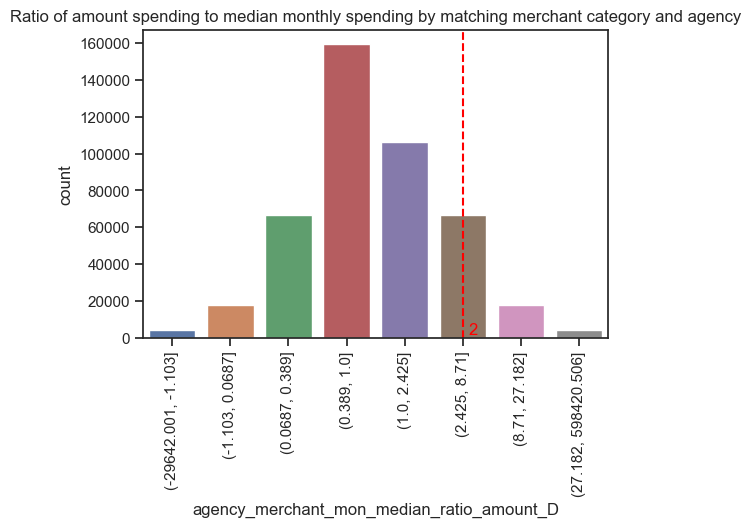

In [26]:
#Plot the histogram of ratio of amount spending and median monthly spending by merchant category and agency in percentile
plt.figure(figsize=(6,4))
g = sns.countplot(x="agency_merchant_mon_median_ratio_amount_D", data=df_mon4)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Ratio of amount spending to median monthly spending by matching merchant category and agency')

plt.axvline(x=5, color='red', linestyle='--')
plt.text(5.1, 0.9, '2', color='red', fontsize=12, verticalalignment='bottom')
plt.show()

The chart displays a normal distribution, which has a similar shape as 3.1c average spending one.

###  3.1e Monetary Feature 5: The ratio to average amount grouped by Agency, Merchant Category, and Week 
The outliers can be detected if the transaction amount greatly deviates the average weekly spending from same agency and merchant category. Here the benchmark is the average spending ratio = 2.

In [27]:
# create average weekly spending group by agency and merchant category
stat_by_mon5 = df.groupby(['Agency_Name', 'Merchant_Category', 'Week_Number'])['Amount'].mean() 
stat_by_mon5 = pd.DataFrame(stat_by_mon5)
stat_by_mon5.columns = ['AVG_amount']

# add the new feature average weekly spending to the dataset 
df_mon5 = pd.merge(df, stat_by_mon5, how='left', on=['Agency_Name', 'Merchant_Category', 'Week_Number'])

df_mon5['agency_merchant_week_avg_ratio_amount'] = np.where(df_mon5['AVG_amount']==0,0, df_mon5['Amount'] / df_mon5['AVG_amount'])
df_mon5['agency_merchant_week_avg_ratio_amount'].describe()

#The values spread into a wide range
#cut by percentile for plotting
var = 'agency_merchant_week_avg_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df_mon5[binned_var] = pd.qcut(df_mon5[var],percentile)
df_mon5[['agency_merchant_week_avg_ratio_amount_D']]

,agency_merchant_week_avg_ratio_amount_D
0,"(1.351, 3.23]"
1,"(1.351, 3.23]"
2,"(0.184, 0.745]"
3,"(1.351, 3.23]"
4,"(0.184, 0.745]"
...,...
442453,"(0.745, 1.351]"
442454,"(1.351, 3.23]"
442455,"(0.029, 0.184]"
442456,"(3.23, 7.324]"


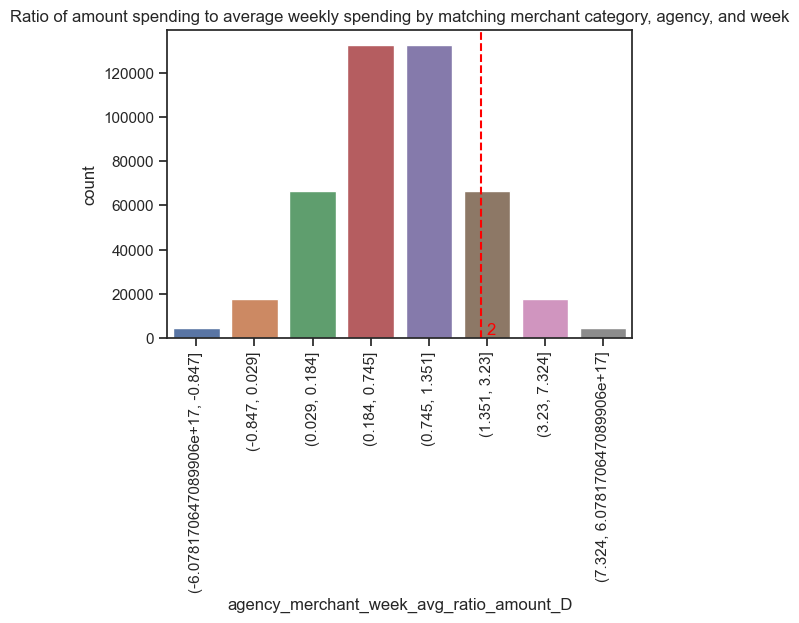

In [28]:
#Plot the histogram of ratio of amount spending and median weekly spending by merchant category and agency in percentile
plt.figure(figsize=(6,4))
g = sns.countplot(x="agency_merchant_week_avg_ratio_amount_D", data=df_mon5)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Ratio of amount spending to average weekly spending by matching merchant category, agency, and week')

plt.axvline(x=4.9, color='red', linestyle='--')
plt.text(5, 0.9, '2', color='red', fontsize=12, verticalalignment='bottom')
plt.show()

###  3.1f Monetary Feature 6: The ratio to median amount grouped by Agency, Merchant Category, and Week
The outliers can be detected if the transaction amount greatly deviates the median weekly spending from same agency and merchant category. Here the benchmark is the median spending ratio = 2.

In [29]:
# create median weekly spending group by agency and merchant category
stat_by_mon6 = df.groupby(['Agency_Name', 'Merchant_Category', 'Week_Number'])['Amount'].median() 
stat_by_mon6 = pd.DataFrame(stat_by_mon6)
stat_by_mon6.columns = ['Median_amount']

# add the new feature average weekly spending to the dataset 
df_mon6 = pd.merge(df, stat_by_mon6, how='left', on=['Agency_Name', 'Merchant_Category', 'Week_Number'])
 
df_mon6['agency_merchant_week_median_ratio_amount'] = np.where(df_mon6['Median_amount']==0,0, df_mon6['Amount'] / df_mon6['Median_amount'])
df_mon6['agency_merchant_week_median_ratio_amount'].describe()

#The values spread into a wide range
#cut by percentile for plotting
var = 'agency_merchant_week_median_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df_mon6[binned_var] = pd.qcut(df_mon6[var],percentile)
df_mon6[['agency_merchant_week_median_ratio_amount_D']]

,agency_merchant_week_median_ratio_amount_D
0,"(2.045, 7.78]"
1,"(1.0, 2.045]"
2,"(1.0, 2.045]"
3,"(2.045, 7.78]"
4,"(1.0, 2.045]"
...,...
442453,"(1.0, 2.045]"
442454,"(1.0, 2.045]"
442455,"(0.437, 1.0]"
442456,"(25.505, 235424.342]"


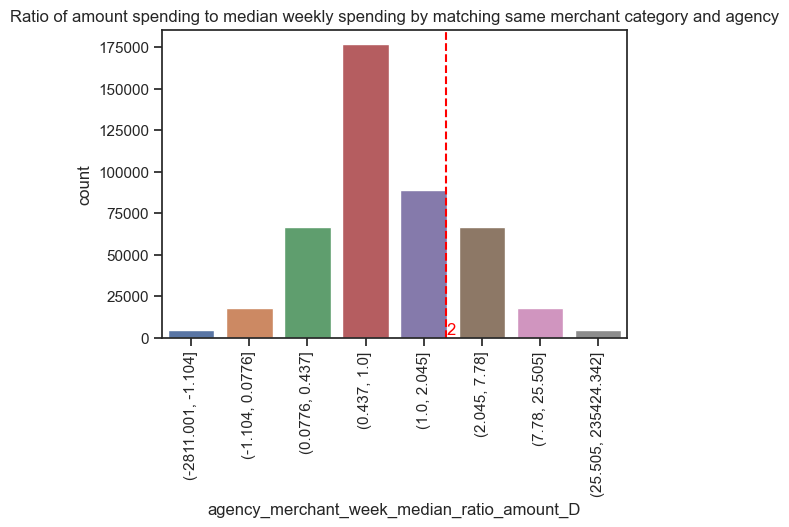

In [30]:
#Plot the histogram of ratio of amount spending and median weekly spending by matching same merchant category and agency in percentile
plt.figure(figsize=(6,4))
g = sns.countplot(x="agency_merchant_week_median_ratio_amount_D", data=df_mon6)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Ratio of amount spending to median weekly spending by matching same merchant category and agency')

plt.axvline(x=4.38, color='red', linestyle='--')
plt.text(4.4, 0.9, '2', color='red', fontsize=12, verticalalignment='bottom')
plt.show()

The median chart shows right-skewed distribution which means the mean ratio is greater than the median ratio.

###  3.1g Monetary Feature 7: The ratio to average amount grouped by Agency, Merchant Category, and Vendor
The outliers can be detected if the transaction amount greatly deviates the average spending from same agency, merchant category, and vendor. Here the benchmark is the average spending ratio = 2.

In [31]:
# create avg spending group by agency, merchant category, and vendor
stat_by_mon7 = df.groupby(['Agency_Name', 'Merchant_Category', 'Vendor'])['Amount'].mean() 
stat_by_mon7 = pd.DataFrame(stat_by_mon7)
stat_by_mon7.columns = ['AVG_amount']

# add the new feature average spending to the dataset 
df_mon7 = pd.merge(df, stat_by_mon7, how='left', on=['Agency_Name', 'Merchant_Category', 'Vendor'])
 
df_mon7['agency_merchant_vendor_avg_ratio_amount'] = np.where(df_mon7['AVG_amount']==0,0, df_mon7['Amount'] / df_mon7['AVG_amount'])
df_mon7['agency_merchant_vendor_avg_ratio_amount'].describe()

#The values spread into a wide range
#cut by percentile for plotting
var = 'agency_merchant_vendor_avg_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df_mon7[binned_var] = pd.qcut(df_mon7[var],percentile)
df_mon7[['agency_merchant_vendor_avg_ratio_amount_D']]

,agency_merchant_vendor_avg_ratio_amount_D
0,"(1.22, 2.788]"
1,"(0.255, 0.958]"
2,"(1.22, 2.788]"
3,"(1.22, 2.788]"
4,"(0.255, 0.958]"
...,...
442453,"(0.04, 0.255]"
442454,"(1.22, 2.788]"
442455,"(1.22, 2.788]"
442456,"(6.116, 6.424384868444013e+16]"


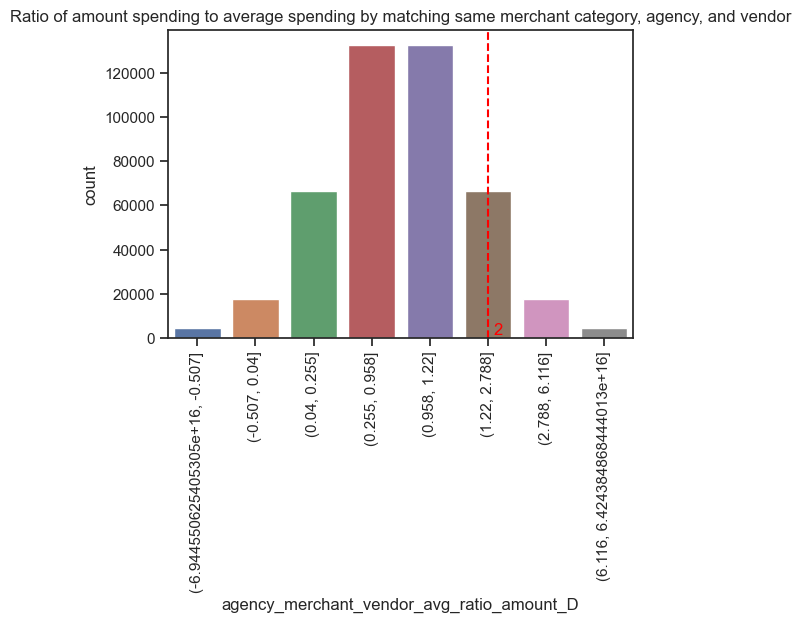

In [32]:
#Plot the histogram of ratio of amount spending and median monthly spending by merchant category, agency, and vendor in percentile
plt.figure(figsize=(6,4))
g = sns.countplot(x="agency_merchant_vendor_avg_ratio_amount_D", data=df_mon7)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Ratio of amount spending to average spending by matching same merchant category, agency, and vendor')

plt.axvline(x=5, color='red', linestyle='--')
plt.text(5.1, 0.9, '2', color='red', fontsize=12, verticalalignment='bottom')
plt.show()

###  3.1h Monetary Feature 8: The ratio to median amount grouped by Agency, Merchant Category, and Vendor
The outliers can be detected if the transaction amount greatly deviates the median spending from same agency, merchant category, and vendor. Here the benchmark is the median spending ratio = 2.

In [33]:
# create median spending group by agency, merchant category, and vendor
stat_by_mon8 = df.groupby(['Agency_Name', 'Merchant_Category', 'Vendor'])['Amount'].mean() 
stat_by_mon8 = pd.DataFrame(stat_by_mon8)
stat_by_mon8.columns = ['AVG_amount']

# add the new feature median spending to the dataset 
df_mon8 = pd.merge(df, stat_by_mon8, how='left', on=['Agency_Name', 'Merchant_Category', 'Vendor'])

df_mon8['agency_merchant_vendor_median_ratio_amount'] = np.where(df_mon8['AVG_amount']==0,0, df_mon8['Amount'] / df_mon8['AVG_amount'])
df_mon8['agency_merchant_vendor_median_ratio_amount'].describe()

#The values spread into a wide range
#cut by percentile for plotting
var = 'agency_merchant_vendor_median_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df_mon8[binned_var] = pd.qcut(df_mon8[var],percentile)
df_mon8[['agency_merchant_vendor_median_ratio_amount_D']]

,agency_merchant_vendor_median_ratio_amount_D
0,"(1.22, 2.788]"
1,"(0.255, 0.958]"
2,"(1.22, 2.788]"
3,"(1.22, 2.788]"
4,"(0.255, 0.958]"
...,...
442453,"(0.04, 0.255]"
442454,"(1.22, 2.788]"
442455,"(1.22, 2.788]"
442456,"(6.116, 6.424384868444013e+16]"


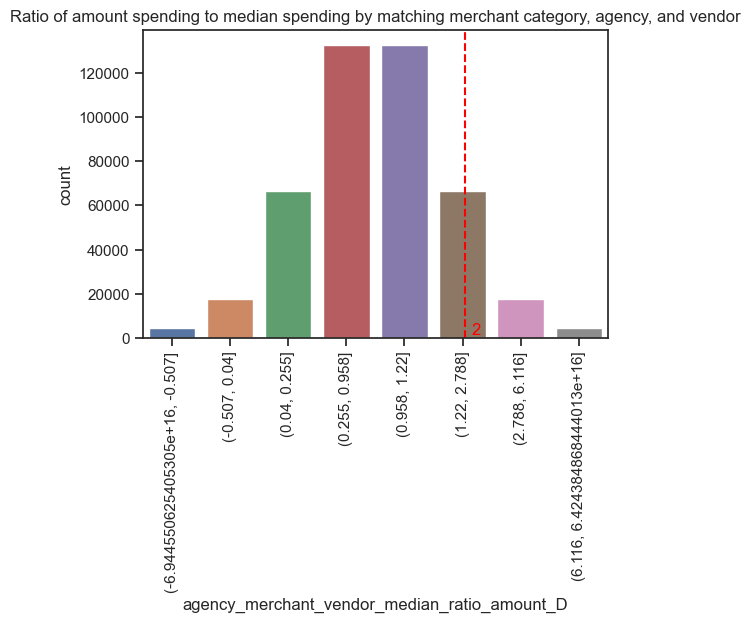

In [34]:
#Plot the histogram of ratio of amount spending and median spending by merchant category, agency, and week number in percentile
plt.figure(figsize=(6,4))
g = sns.countplot(x="agency_merchant_vendor_median_ratio_amount_D", data=df_mon8)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Ratio of amount spending to median spending by matching merchant category, agency, and vendor')

plt.axvline(x=5.05, color='red', linestyle='--')
plt.text(5.15, 0.9, '2', color='red', fontsize=12, verticalalignment='bottom')
plt.show()

###  3.1i Monetary Feature 9: Each cardholder's monthly transaction amount with 95% CI
The outliers can be detected if each cardholder's monthly transaction amount is greater than the 95% of confidence interval.

In [35]:
# Sort the cardholder and transaction date
df_mon9 = df.sort_values(['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Month'])

# Calculate the difference in days between consecutive transaction dates for each cardholder
df_mon9['Amount_Diff'] = df.groupby(['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Month'])['Amount'].diff()

# Grouped by cardholder and calculate the normal distribution parameters
grouped_9 = df_mon9.groupby(['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Month'])['Amount']
mean = grouped_9.mean()
std = grouped_9.std()

In [36]:
# Create a DataFrame to store the results
stat_by_mon9 = pd.DataFrame({'Mean': mean,
                             'Std': std})
# add the new feature average spending to the dataset 
df_mon9 = df_mon9.merge(stat_by_mon9[['Mean', 'Std']], left_on=['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Month'], right_on=['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Month'], how='left')

df_mon9['upper_CI'] = np.where(df_mon9['Mean']==0, 0, df_mon9['Mean'] + 1.96*df_mon9['Std'])
df_mon9.head()

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Day_of_Week,Amount_Diff,Mean,Std,upper_CI
0,2014-04-01,15000,UNIV.OF SCIENCE & ARTS OF OK,15000,1,GENERAL PURCHASE,4626.46,PAYMENT ADJUSTMENT,2014-03-10,2014-04-07,OTHER FEES,2014,4,11,Monday,NaN,4626.460,NaN,NaN
1,2014-01-01,24100,REDLANDS COMMUNITY COLLEGE,24100,2,GENERAL PURCHASE,0.77,PURCHASE FINANCE CHARGE,2014-01-15,2014-01-15,OTHER FEES,2014,1,3,Wednesday,NaN,0.770,NaN,NaN
2,2014-03-01,24100,REDLANDS COMMUNITY COLLEGE,24100,2,GENERAL PURCHASE,-35.29,CREDIT PURCHASE FINANCE C,2014-03-14,2014-03-25,OTHER FEES,2014,3,11,Friday,NaN,-17.640,24.960869,31.283304
3,2014-03-01,24100,REDLANDS COMMUNITY COLLEGE,24100,2,GENERAL PURCHASE,0.01,PURCHASE FINANCE CHARGE,2014-03-14,2014-03-14,OTHER FEES,2014,3,11,Friday,35.3,-17.640,24.960869,31.283304
4,2013-07-01,24100,REDLANDS COMMUNITY COLLEGE,24100,2,GENERAL PURCHASE,16.90,PURCHASE FINANCE CHARGE,2013-07-15,2013-07-15,OTHER FEES,2013,7,29,Monday,NaN,906.495,1258.077314,3372.326535


In [37]:
#Filter out the consecutive transaction time passed is over 95% of the upper confidence interval
rec_outlier_mon9 = df_mon9[(df_mon9['Amount_Diff']>df_mon9['upper_CI']) & (df_mon9['upper_CI'] >= 0)]

#Plot the table of outlier
table_mon9 = pd.pivot_table(rec_outlier_mon9, values=['Amount_Diff', 'Mean', 'Std', 'upper_CI'], index=['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Month'])
table_mon9.head()

Amount_Diff       Mean  \
Cardholder_Last_Name Cardholder_First_Initial Month                           
24100                2                        3            35.30  -17.64000   
88000                8                        7           500.00    0.00000   
ACREE                T                        6          2955.21  425.76875   
                                              10          523.55  153.01000   
ADAMS                K                        9           624.96  171.13000   

                                                             Std     upper_CI  
Cardholder_Last_Name Cardholder_First_Initial Month                            
24100                2                        3        24.960869    31.283304  
88000                8                        7       353.553391     0.000000  
ACREE                T                        6      1058.273217  2499.984255  
                                              10      181.422280   508.597669  
ADAMS                K                        9       209.002225   580.774362

###  3.1j Monetary Feature 10: Each cardholder's weekly transaction amount with 95% CI
The outliers can be detected if each cardholder's weekly transaction amount is greater than the 95% of confidence interval.

In [38]:
# Sort the cardholder and Week
df_mon10 = df.sort_values(['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Week_Number'])

# Calculate the difference in days between consecutive transaction dates for each cardholder
df_mon10['Amount_Diff'] = df.groupby(['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Week_Number'])['Amount'].diff()

# Grouped by cardholder and calculate the normal distribution parameters
grouped_10 = df_mon10.groupby(['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Week_Number'])['Amount']
mean = grouped_10.mean()
std = grouped_10.std()


# Create a DataFrame to store the results
stat_by_mon10 = pd.DataFrame({'Mean': mean,
                             'Std': std})
# add the new feature average spending to the dataset 
df_mon10 = df_mon10.merge(stat_by_mon10[['Mean', 'Std']], left_on=['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Week_Number'], right_on=['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Week_Number'], how='left')

df_mon10['upper_CI'] = np.where(df_mon10['Mean']==0, 0, df_mon10['Mean'] + 1.96*df_mon10['Std'])
df_mon10.head()

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Day_of_Week,Amount_Diff,Mean,Std,upper_CI
0,2014-04-01,15000,UNIV.OF SCIENCE & ARTS OF OK,15000,1,GENERAL PURCHASE,4626.46,PAYMENT ADJUSTMENT,2014-03-10,2014-04-07,OTHER FEES,2014,4,11,Monday,NaN,4626.46,NaN,NaN
1,2014-01-01,24100,REDLANDS COMMUNITY COLLEGE,24100,2,GENERAL PURCHASE,0.77,PURCHASE FINANCE CHARGE,2014-01-15,2014-01-15,OTHER FEES,2014,1,3,Wednesday,NaN,0.77,NaN,NaN
2,2014-03-01,24100,REDLANDS COMMUNITY COLLEGE,24100,2,GENERAL PURCHASE,-35.29,CREDIT PURCHASE FINANCE C,2014-03-14,2014-03-25,OTHER FEES,2014,3,11,Friday,NaN,-17.64,24.960869,31.283304
3,2014-03-01,24100,REDLANDS COMMUNITY COLLEGE,24100,2,GENERAL PURCHASE,0.01,PURCHASE FINANCE CHARGE,2014-03-14,2014-03-14,OTHER FEES,2014,3,11,Friday,35.3,-17.64,24.960869,31.283304
4,2013-07-01,24100,REDLANDS COMMUNITY COLLEGE,24100,2,GENERAL PURCHASE,16.90,PURCHASE FINANCE CHARGE,2013-07-15,2013-07-15,OTHER FEES,2013,7,29,Monday,NaN,16.90,NaN,NaN


In [39]:
#Filter out the consecutive transaction time passed is over 95% of the upper confidence interval
rec_outlier_mon10 = df_mon10[(df_mon10['Amount_Diff']>df_mon10['upper_CI']) & (df_mon10['upper_CI'] >= 0)]

#Plot the table of outlier
table_mon10 = pd.pivot_table(rec_outlier_mon10, values=['Amount_Diff', 'Mean', 'Std', 'upper_CI'], index=['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Week_Number'])
table_mon10.head()

,,,Amount_Diff,Mean,Std,upper_CI
Cardholder_Last_Name,Cardholder_First_Initial,Week_Number,,,,
24100,2,11,35.30,-17.640000,24.960869,31.283304
77000,7,19,0.16,0.000000,0.092376,0.000000
88000,8,28,500.00,0.000000,353.553391,0.000000
ADMIRE,A,15,798.25,179.041429,286.593988,740.765646
AGNELLI,M,12,1127.66,208.165000,370.273446,933.900954


###  3.1k Monetary Feature 11: The ratio of each cardholder's daily amount to an average monthly amount
The outliers can be detected if th ratio of each cardholder's overall daily transaction is greater than the average monthly transaction.

In [40]:
#grouped by Cardholder's last and first names and Month
stat_by_AllTrans = df.groupby(['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Month'])['Amount'].mean() 
stat_by_AllTrans = pd.DataFrame(stat_by_AllTrans)
stat_by_AllTrans.columns = ['AVG_amount']
stat_by_AllTrans.head()

AVG_amount
Cardholder_Last_Name Cardholder_First_Initial Month            
15000                1                        4        4626.460
24100                2                        1           0.770
                                              3         -17.640
                                              7         906.495
                                              8         374.515

In [41]:
# add the new feature average spending to the dataset 
df4 = pd.merge(df, stat_by_AllTrans, how='left', on=['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Month'])
# Feature 1: ratio of amount spending and avergae spending by merchant category 
df4['all_trans_month_avg_ratio_amount'] = np.where(df4['AVG_amount']==0,0, df4['Amount'] / df4['AVG_amount'])
df4['all_trans_month_avg_ratio_amount'].describe()

count    4.424580e+05
mean     9.969590e-01
std      1.483136e+14
min     -7.151575e+16
25%      1.612844e-01
50%      5.431929e-01
75%      1.307389e+00
max      6.403556e+16
Name: all_trans_month_avg_ratio_amount, dtype: float64

In [42]:
var = 'all_trans_month_avg_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df4[binned_var] = pd.qcut(df4[var],percentile)
df4[['all_trans_month_avg_ratio_amount_D']]

,all_trans_month_avg_ratio_amount_D
0,"(1.582, 3.615]"
1,"(0.543, 1.582]"
2,"(0.116, 0.543]"
3,"(0.116, 0.543]"
4,"(0.543, 1.582]"
...,...
442453,"(0.116, 0.543]"
442454,"(0.116, 0.543]"
442455,"(0.0193, 0.116]"
442456,"(3.615, 7.209]"


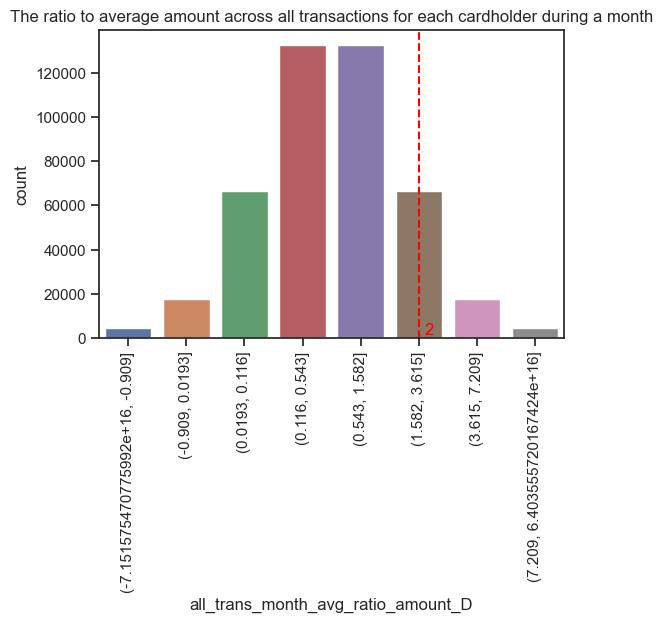

In [43]:
#Plot the histogram of the ratio to average amount across all transactions for each cardholder during a month
plt.figure(figsize=(6,4))
g = sns.countplot(x="all_trans_month_avg_ratio_amount_D", data=df4)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('The ratio to average amount across all transactions for each cardholder during a month')

plt.axvline(x=5, color='red', linestyle='--')
plt.text(5.1, 0.9, '2', color='red', fontsize=12, verticalalignment='bottom')

plt.show()

The ratio to average amount across all transactions for each cardholder during a month displays a normal distribution where the outliers come out when the confidence interval is roughly greater than 68%.

In [44]:
df4[df4['all_trans_month_avg_ratio_amount'] > 2].sort_values('all_trans_month_avg_ratio_amount', ascending=False).head()

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Day_of_Week,AVG_amount,all_trans_month_avg_ratio_amount,all_trans_month_avg_ratio_amount_D
61186,2014-01-01,1000,OKLAHOMA STATE UNIVERSITY,Rash,C,GENERAL PURCHASE,-455.00,THE ATHERTON HOTL AT OSU,2014-01-27,2014-01-29,"LODGING--HOTELS,MOTELS,AND RESORTS",2014,1,5,Monday,-7.105427e-15,6.403556e+16,"(7.209, 6.403555720167424e+16]"
18338,2013-08-01,1000,OKLAHOMA STATE UNIVERSITY,Dady,L,GENERAL PURCHASE,2393.88,TARGET.COM,2013-08-22,2013-08-22,DISCOUNT STORES,2013,8,34,Thursday,1.515825e-13,1.579259e+16,"(7.209, 6.403555720167424e+16]"
61188,2014-01-01,1000,OKLAHOMA STATE UNIVERSITY,Rash,C,GENERAL PURCHASE,-53.15,THE ATHERTON HOTL AT OSU,2014-01-26,2014-01-29,"LODGING--HOTELS,MOTELS,AND RESORTS",2014,1,4,Sunday,-7.105427e-15,7.480198e+15,"(7.209, 6.403555720167424e+16]"
196135,2013-12-01,76000,UNIVERSITY OF OKLAHOMA,SHAHAN,K,GENERAL PURCHASE,-29.64,AMAZON MKTPLACE PMTS,2013-12-14,2013-12-16,BOOK STORES,2013,12,50,Saturday,-6.666667e-03,4.446000e+03,"(7.209, 6.403555720167424e+16]"
196898,2013-12-01,76000,UNIVERSITY OF OKLAHOMA,SHAHAN,K,GENERAL PURCHASE,-7.36,AMAZON MKTPLACE PMTS,2013-12-17,2013-12-18,BOOK STORES,2013,12,51,Tuesday,-6.666667e-03,1.104000e+03,"(7.209, 6.403555720167424e+16]"


**Thinking Process**

Because the first and third rows display that C. Rash's transactions amount has unusually exceeded the his or her average transaction amount massively in January 2014 so I filter out his total transaction in January to see whether there were a lower January's average transaction amount in other years.

In [45]:
# check C. Rash's total transactions in January 2014
df4[(df4['Cardholder_Last_Name'] == 'Rash') & (df4['Cardholder_First_Initial'] == 'C') & (df4['Month'] == 1)].head()

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Day_of_Week,AVG_amount,all_trans_month_avg_ratio_amount,all_trans_month_avg_ratio_amount_D
61186,2014-01-01,1000,OKLAHOMA STATE UNIVERSITY,Rash,C,GENERAL PURCHASE,-455.00,THE ATHERTON HOTL AT OSU,2014-01-27,2014-01-29,"LODGING--HOTELS,MOTELS,AND RESORTS",2014,1,5,Monday,-7.105427e-15,6.403556e+16,"(7.209, 6.403555720167424e+16]"
61187,2014-01-01,1000,OKLAHOMA STATE UNIVERSITY,Rash,C,ROOM CHARGES,508.15,THE ATHERTON HOTL AT OSU,2014-01-25,2014-01-29,"LODGING--HOTELS,MOTELS,AND RESORTS",2014,1,4,Saturday,-7.105427e-15,-7.151575e+16,"(-7.151575470775992e+16, -0.909]"
61188,2014-01-01,1000,OKLAHOMA STATE UNIVERSITY,Rash,C,GENERAL PURCHASE,-53.15,THE ATHERTON HOTL AT OSU,2014-01-26,2014-01-29,"LODGING--HOTELS,MOTELS,AND RESORTS",2014,1,4,Sunday,-7.105427e-15,7.480198e+15,"(7.209, 6.403555720167424e+16]"


**Thinking Process**

Because the second row shows that L. Dady's transaction amount has unusually exceeded the his or her average transaction amount massively in August 2013 so I filter out his total transaction in August to see whether there were other August's transactions affect its average ratio.

In [46]:
# check L. Dady's total transactions in August 2013
df4[(df4['Cardholder_Last_Name'] == 'Dady') & (df4['Cardholder_First_Initial'] == 'L') & (df4['Month'] == 8)].head()

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Day_of_Week,AVG_amount,all_trans_month_avg_ratio_amount,all_trans_month_avg_ratio_amount_D
10472,2013-08-01,1000,OKLAHOMA STATE UNIVERSITY,Dady,L,GENERAL PURCHASE,-2199.99,TARGET.COM,2013-08-30,2013-08-30,DISCOUNT STORES,2013,8,35,Friday,1.515825e-13,-1.451349e+16,"(-7.151575470775992e+16, -0.909]"
18097,2013-08-01,1000,OKLAHOMA STATE UNIVERSITY,Dady,L,GENERAL PURCHASE,-193.89,TARGET.COM,2013-08-18,2013-08-19,DISCOUNT STORES,2013,8,33,Sunday,1.515825e-13,-1.279106e+15,"(-7.151575470775992e+16, -0.909]"
18338,2013-08-01,1000,OKLAHOMA STATE UNIVERSITY,Dady,L,GENERAL PURCHASE,2393.88,TARGET.COM,2013-08-22,2013-08-22,DISCOUNT STORES,2013,8,34,Thursday,1.515825e-13,1.579259e+16,"(7.209, 6.403555720167424e+16]"


#### Conclusion
Based on the sorted all transactions monthly average ratio result, Both C. Rash and L. Dady's monthly transaction average ratios are affected by the refund money towards their bank account. However, there is something that needs to notice that refund, in general, is transacted after the behaviour of purchase occurs. In the case of L. Dady, one of the refund happened before the purchase; if the late purchase is result from the technical issue of pre-authorisation process, this outlier would not be dubious as it was.

###  3.1m Monetary Feature 12: The ratio of each cardholder's daily amount to an average monthly amount with same agency, merchant category, and vendor
This feature could capture the outliers more profoundly with more charateristics combined. The anomalies can be detected if th ratio of each cardholder's overall daily transaction is 2 times greater than the average monthly transaction.

In [47]:
#grouped by Cardholder's last and first names and year
stat_by_mon10 = df.groupby(['Agency_Name', 'Merchant_Category', 'Cardholder_Last_Name', 'Cardholder_First_Initial', 'Vendor', 'Month'])['Amount'].mean() 
stat_by_mon10 = pd.DataFrame(stat_by_mon10)
stat_by_mon10.columns = ['AVG_amount']
stat_by_mon10.head()

# add the new feature average spending to the dataset 
df10 = pd.merge(df, stat_by_mon10, how='left', on=['Agency_Name', 'Merchant_Category', 'Cardholder_Last_Name', 'Cardholder_First_Initial', 'Vendor', 'Month'])
# Feature 1: ratio of amount spending and avergae spending by merchant category 
df10['all_trans_mon12_avg_ratio_amount'] = np.where(df10['AVG_amount']==0,0, df10['Amount'] / df10['AVG_amount'])
df10['all_trans_mon12_avg_ratio_amount'].describe()

var = 'all_trans_mon12_avg_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df10[binned_var] = pd.qcut(df10[var],percentile,duplicates='drop')
df10[['all_trans_mon12_avg_ratio_amount_D']]

,all_trans_mon12_avg_ratio_amount_D
0,"(0.699, 1.0]"
1,"(1.0, 2.016]"
2,"(0.699, 1.0]"
3,"(0.699, 1.0]"
4,"(0.699, 1.0]"
...,...
442453,"(0.101, 0.699]"
442454,"(0.101, 0.699]"
442455,"(1.0, 2.016]"
442456,"(0.699, 1.0]"


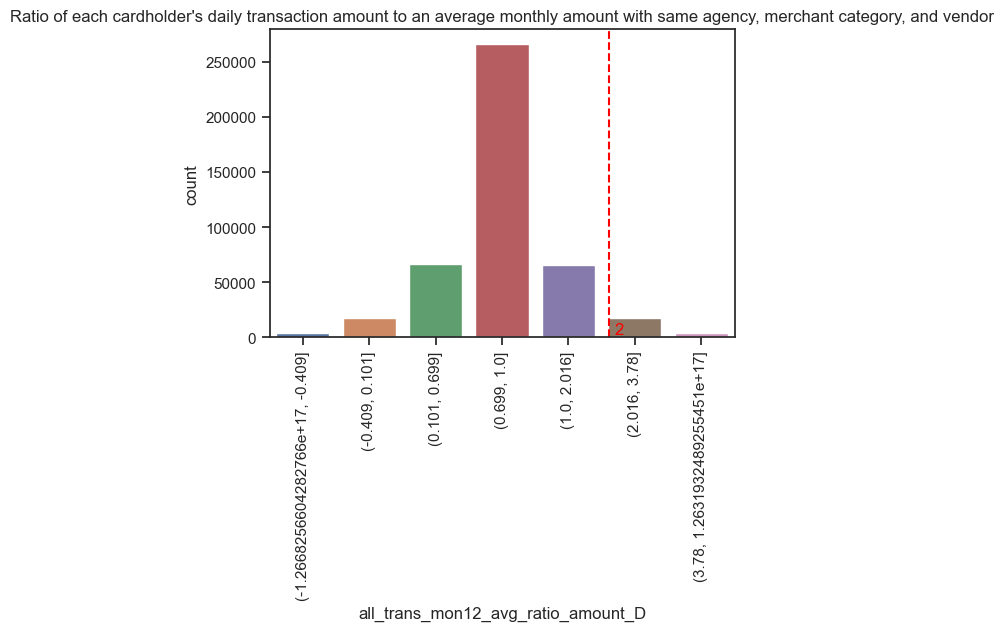

In [48]:
#Plot the histogram
plt.figure(figsize=(6,4))
g = sns.countplot(x="all_trans_mon12_avg_ratio_amount_D", data=df10)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title("Ratio of each cardholder's daily transaction amount to an average monthly amount with same agency, merchant category, and vendor")

plt.axvline(x=4.61, color='red', linestyle='--')
plt.text(4.7, 0.9, '2', color='red', fontsize=12, verticalalignment='bottom')

plt.show()

The chart shows a normal distribution with a skinny bell-shaped which it has very small standard deviation comparing to a standard normal distribution.

###  3.2a Frequency Feature 1: Each cardholder's monthly transaction frequency with the same merchant category

If we look at the ratio of monthly frequency to total number of transactions by matching certain variables, we might find the anomalies (i.e., dubious transactions). According to the analysis below, this has suggested that the benchmark for frequency would be 0.5 in medium term. Therefore, in this frequency feature, the outlier is defined as the ratio is over 0.5.

In [49]:
#grouped by Cardholder's last and first names, merchant category, and month; then calculate the monthly freq
stat_by_freq1 = df.groupby(['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Merchant_Category', 'Month']).size().reset_index(name='Count')
stat_by_freq1 = pd.DataFrame(stat_by_freq1)
stat_by_freq1

,Cardholder_Last_Name,Cardholder_First_Initial,Merchant_Category,Month,Count
0,15000,1,OTHER FEES,4,1
1,24100,2,OTHER FEES,1,1
2,24100,2,OTHER FEES,3,2
3,24100,2,OTHER FEES,7,2
4,24100,2,OTHER FEES,8,2
...,...,...,...,...,...
185225,russell,s,RESIDENCE INN,6,1
185226,russell,s,SLEEP INN,6,1
185227,russell,s,SOUTHWEST AIRLINES,6,4
185228,russell,s,TRAVEL AGENCIES,6,5


#### Add up the monthly frequency

In [50]:
#stat_by_freq1 = stat_by_freq1.drop(['Average_Count'], axis=1)
stat_by_freq1['Sum_Count'] = stat_by_freq1.groupby(['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Merchant_Category'])['Count'].transform('sum')
stat_by_freq1.head(15)

,Cardholder_Last_Name,Cardholder_First_Initial,Merchant_Category,Month,Count,Sum_Count
0,15000,1,OTHER FEES,4,1,1
1,24100,2,OTHER FEES,1,1,10
2,24100,2,OTHER FEES,3,2,10
3,24100,2,OTHER FEES,7,2,10
4,24100,2,OTHER FEES,8,2,10
5,24100,2,OTHER FEES,9,1,10
6,24100,2,OTHER FEES,12,2,10
7,42000,4,OTHER FEES,1,2,16
8,42000,4,OTHER FEES,2,2,16
9,42000,4,OTHER FEES,3,2,16


#### Get the ratio of monthly frequency from same cardholder and merchant category

In [51]:
# add the new feature average spending to the dataset 
df5 = pd.merge(df, stat_by_freq1, how='left', on=['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Merchant_Category', 'Month'])
# Feature 1: ratio of amount spending and avergae spending by merchant category 
df5['freq1'] = np.where(df5['Count']==0,0, df5['Count'] / df5['Sum_Count'])
df5['freq1'].describe()

count    442458.000000
mean          0.292094
std           0.290224
min           0.000997
25%           0.094118
50%           0.166667
75%           0.358974
max           1.000000
Name: freq1, dtype: float64

**Thinking Process**

The monthly frequency ratio to overall number of transactions by matching same cardholder and merchant category could mostly be 1 and which is normally reasonable within 1-year period because it is reasonable that people might just have one-time purchase at that merchant category within short period. If the transaction data timeframe is 5-10 years, then the ratio equals to 1 should be considered into the feature. At this point, I choose to remove the ratio that equals 1.

In [52]:
df5 = df5.sort_values('freq1', ascending=False)
df5 = df5[df5['freq1'] != 1]
df5.head()

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Day_of_Week,Count,Sum_Count,freq1
78645,2013-07-01,13100,DEPARTMENT OF CORRECTIONS,Chandler,S,SOL .9NACL 1000ML DRUG CS,43.50,MCKESSON MEDICAL SUPPLY,2013-07-24,2013-07-25,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,2013,7,30,Wednesday,91,92,0.98913
80577,2013-07-01,13100,DEPARTMENT OF CORRECTIONS,Chandler,S,GENERAL PURCHASE,-87.75,MCKESSON MEDICAL SUPPLY,2013-07-26,2013-07-31,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,2013,7,30,Friday,91,92,0.98913
78552,2013-07-01,13100,DEPARTMENT OF CORRECTIONS,Chandler,S,OVERLAY 35X72X31/2'' FMCV EA,139.92,MCKESSON MEDICAL SUPPLY,2013-07-18,2013-07-19,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,2013,7,29,Thursday,91,92,0.98913
78551,2013-07-01,13100,DEPARTMENT OF CORRECTIONS,Chandler,S,LANCETS TECHLITE 100S 25G BX,7.65,MCKESSON MEDICAL SUPPLY,2013-07-18,2013-07-19,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,2013,7,29,Thursday,91,92,0.98913
78646,2013-07-01,13100,DEPARTMENT OF CORRECTIONS,Chandler,S,TIP OTOSCOPE DISP 4MM BX,26.19,MCKESSON MEDICAL SUPPLY,2013-07-24,2013-07-25,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,2013,7,30,Wednesday,91,92,0.98913


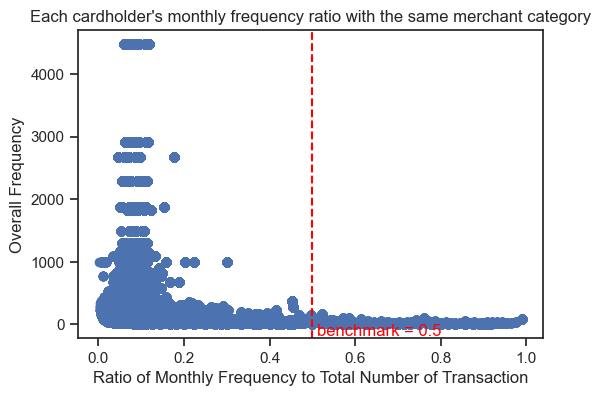

In [53]:
plt.figure(figsize=(6,4))
plt.scatter(df5['freq1'], df5['Sum_Count'])
plt.xlabel('Ratio of Monthly Frequency to Total Number of Transaction')
plt.ylabel('Overall Frequency')
plt.title("Each cardholder's monthly frequency ratio with the same merchant category")

plt.axvline(x=0.5, color='red', linestyle='--')
plt.text(0.51, 0.9, 'benchmark = 0.5', color='red', fontsize=12, verticalalignment='top')
plt.show()


###  3.2b Frequency Feature 2: Each cardholder's monthly transaction frequency with the same merchant category and agency

This is the extended feature based on 3.1a frequency feature 1, which this feature takes agency into account.

In [54]:
#grouped by Agency_Name, Cardholder's last and first names, merchant category, and Month; then calculate the monthly freq
stat_by_freq2 = df.groupby(['Agency_Name', 'Cardholder_Last_Name', 'Cardholder_First_Initial', 'Merchant_Category', 'Month']).size().reset_index(name='Count')
stat_by_freq2 = pd.DataFrame(stat_by_freq2)
stat_by_freq2

,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Merchant_Category,Month,Count
0,ARDMORE HIGHER EDUCATION CENTER,Pollard,C,COMPUTER NETWORK/INFORMATION SERVICES,10,1
1,ARDMORE HIGHER EDUCATION CENTER,Pollard,C,MISCELLANEOUS AND SPECIALTY RETAIL STORES,11,1
2,ARDMORE HIGHER EDUCATION CENTER,Pollard,C,SCHOOLS AND EDUCATIONAL SERVICES NOT ELSEWHERE...,9,1
3,ARDMORE HIGHER EDUCATION CENTER,Ray,M,BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED,11,1
4,ARDMORE HIGHER EDUCATION CENTER,Ray,M,CATALOG MERCHANTS,7,2
...,...,...,...,...,...,...
185942,`DEPARTMENT OF EDUCATION,Ross,P,UNITED AIRLINES,9,8
185943,`DEPARTMENT OF EDUCATION,Ross,P,UNITED AIRLINES,10,5
185944,`DEPARTMENT OF EDUCATION,Ross,P,UNITED AIRLINES,12,6
185945,`DEPARTMENT OF EDUCATION,Ross,P,WYNDHAM HOTELS,1,1


In [55]:
#stat_by_freq2 = stat_by_freq2.drop(['Average_Count'], axis=1)
stat_by_freq2['Sum_Count'] = stat_by_freq2.groupby(['Agency_Name', 'Cardholder_Last_Name', 'Cardholder_First_Initial', 'Merchant_Category'])['Count'].transform('sum')
stat_by_freq2.head()

,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Merchant_Category,Month,Count,Sum_Count
0,ARDMORE HIGHER EDUCATION CENTER,Pollard,C,COMPUTER NETWORK/INFORMATION SERVICES,10,1,1
1,ARDMORE HIGHER EDUCATION CENTER,Pollard,C,MISCELLANEOUS AND SPECIALTY RETAIL STORES,11,1,1
2,ARDMORE HIGHER EDUCATION CENTER,Pollard,C,SCHOOLS AND EDUCATIONAL SERVICES NOT ELSEWHERE...,9,1,1
3,ARDMORE HIGHER EDUCATION CENTER,Ray,M,BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED,11,1,1
4,ARDMORE HIGHER EDUCATION CENTER,Ray,M,CATALOG MERCHANTS,7,2,7


In [56]:
# add the new feature monthly frequency ratio of the number of transaction to the dataset 
df_freq2 = pd.merge(df, stat_by_freq2, how='left', on=['Agency_Name', 'Cardholder_Last_Name', 'Cardholder_First_Initial', 'Merchant_Category', 'Month'])

df_freq2['freq2'] = np.where(df_freq2['Count']==0,0, df_freq2['Count'] / df_freq2['Sum_Count'])
df_freq2['freq2'].describe()

count    442458.000000
mean          0.296364
std           0.292425
min           0.000997
25%           0.095238
50%           0.166667
75%           0.375000
max           1.000000
Name: freq2, dtype: float64

In [57]:
df_freq2 = df_freq2.sort_values('freq2', ascending=False)
df_freq2 = df_freq2[df_freq2['freq2'] != 1]
df_freq2.head()

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Day_of_Week,Count,Sum_Count,freq2
155888,2013-11-01,66500,S. W. OKLA. ST. UNIV.,Cocannouer,D,ROOM CHARGES,53.5,DELUXE INN,2013-11-09,2013-11-11,"LODGING--HOTELS,MOTELS,AND RESORTS",2013,11,45,Saturday,41,42,0.97619
155896,2013-11-01,66500,S. W. OKLA. ST. UNIV.,Cocannouer,D,ROOM CHARGES,53.5,DELUXE INN,2013-11-09,2013-11-11,"LODGING--HOTELS,MOTELS,AND RESORTS",2013,11,45,Saturday,41,42,0.97619
155877,2013-11-01,66500,S. W. OKLA. ST. UNIV.,Cocannouer,D,ROOM CHARGES,53.5,DELUXE INN,2013-11-09,2013-11-11,"LODGING--HOTELS,MOTELS,AND RESORTS",2013,11,45,Saturday,41,42,0.97619
155872,2013-11-01,66500,S. W. OKLA. ST. UNIV.,Cocannouer,D,ROOM CHARGES,53.5,DELUXE INN,2013-11-09,2013-11-11,"LODGING--HOTELS,MOTELS,AND RESORTS",2013,11,45,Saturday,41,42,0.97619
155876,2013-11-01,66500,S. W. OKLA. ST. UNIV.,Cocannouer,D,ROOM CHARGES,53.5,DELUXE INN,2013-11-09,2013-11-11,"LODGING--HOTELS,MOTELS,AND RESORTS",2013,11,45,Saturday,41,42,0.97619


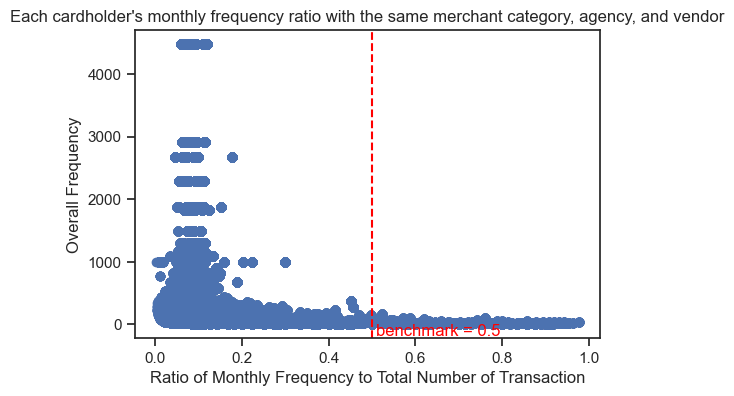

In [58]:
plt.figure(figsize=(6,4))
plt.scatter(df_freq2['freq2'], df_freq2['Sum_Count'])
plt.xlabel('Ratio of Monthly Frequency to Total Number of Transaction')
plt.ylabel('Overall Frequency')
plt.title("Each cardholder's monthly frequency ratio with the same merchant category, agency, and vendor")

plt.axvline(x=0.5, color='red', linestyle='--')
plt.text(0.51, 0.9, 'benchmark = 0.5', color='red', fontsize=12, verticalalignment='top')
plt.show()

###  3.2c Frequency Feature 3: Each cardholder's monthly transaction frequency with the same merchant category , agency, and vendor

In [59]:
#grouped by Agency_Name, Cardholder's last and first names, merchant category, vendor, and Month; then calculate the monthly frequency
stat_by_freq3 = df.groupby(['Agency_Name', 'Cardholder_Last_Name', 'Cardholder_First_Initial', 'Vendor', 'Merchant_Category', 'Month']).size().reset_index(name='Count')
stat_by_freq3 = pd.DataFrame(stat_by_freq3)

stat_by_freq3['Sum_Count'] = stat_by_freq3.groupby(['Agency_Name', 'Cardholder_Last_Name', 'Cardholder_First_Initial', 'Vendor', 'Merchant_Category'])['Count'].transform('sum')

df_freq3 = pd.merge(df, stat_by_freq3, how='left', on=['Agency_Name', 'Cardholder_Last_Name', 'Cardholder_First_Initial', 'Vendor', 'Merchant_Category', 'Month'])

df_freq3['freq3'] = np.where(df_freq3['Count']==0,0, df_freq3['Count'] / df_freq3['Sum_Count'])

df_freq3 = df_freq3.sort_values('freq3', ascending=False)
df_freq3 = df_freq3[df_freq3['freq3'] != 1]
df_freq3.head()

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Day_of_Week,Count,Sum_Count,freq3
81941,2013-08-01,13100,DEPARTMENT OF CORRECTIONS,Hawkins,S,SYR/NDL SFTY 3CC 22GX1.5' BX|SLEEVE KNEE 8'' M...,880.94,MCKESSON MEDICAL SUPPLY,2013-08-03,2013-08-05,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,2013,8,31,Saturday,33,34,0.970588
81831,2013-08-01,13100,DEPARTMENT OF CORRECTIONS,Hawkins,S,TAPE PAPER 3''X10YD BX|TRAY WOUND CARE W/NW TW...,222.55,MCKESSON MEDICAL SUPPLY,2013-08-03,2013-08-05,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,2013,8,31,Saturday,33,34,0.970588
81945,2013-08-01,13100,DEPARTMENT OF CORRECTIONS,Hawkins,S,CATH IV VNSHPT 18GX1 1/4' BX,90.48,MCKESSON MEDICAL SUPPLY,2013-08-04,2013-08-05,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,2013,8,31,Sunday,33,34,0.970588
81180,2013-08-01,13100,DEPARTMENT OF CORRECTIONS,Hawkins,S,GENERAL PURCHASE,58.40,MCKESSON MEDICAL SUPPLY,2013-08-09,2013-08-12,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,2013,8,32,Friday,33,34,0.970588
81946,2013-08-01,13100,DEPARTMENT OF CORRECTIONS,Hawkins,S,SUPPORT ANKLE LG EA|MACHINE SUCTION HVY DUTY E...,191.19,MCKESSON MEDICAL SUPPLY,2013-08-03,2013-08-05,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,2013,8,31,Saturday,33,34,0.970588


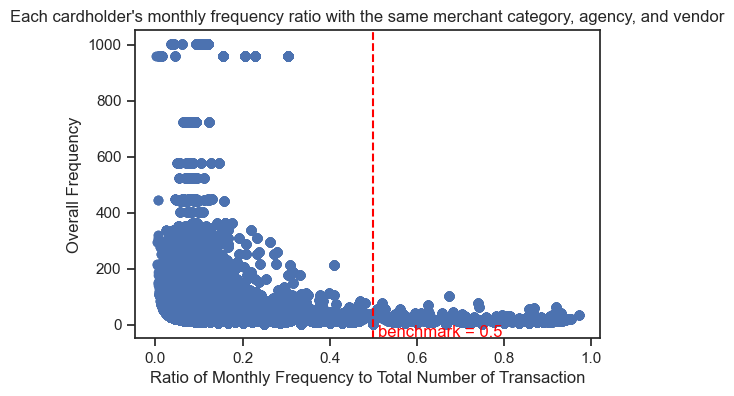

In [60]:
plt.figure(figsize=(6,4))
plt.scatter(df_freq3['freq3'], df_freq3['Sum_Count'])
plt.xlabel('Ratio of Monthly Frequency to Total Number of Transaction')
plt.ylabel('Overall Frequency')
plt.title("Each cardholder's monthly frequency ratio with the same merchant category, agency, and vendor")

plt.axvline(x=0.5, color='red', linestyle='--')
plt.text(0.51, 0.9, 'benchmark = 0.5', color='red', fontsize=12, verticalalignment='top')
plt.show()

#### Conclusion in section 3.2a-c Monthly Frequency Features
These charts are depicted as monthly frequency ratio with the same cardholder, merchant category, and agency name, which detects the outliers when the monthly frequency ratio is greater than 0.5. Their outliers are located on the right hand side of the vertical benchmark line which the monthly frequency ratio to the total number of transaction is 0.5.

###  3.3a Recency Feature 1: The periodic normal contribution of consecutive transaction from each cardholder. 
My assumption here is the cardholder who is expected to make transactions at similar hours or days. The benchmark here is set as 95% confidence interval. Instead of using arithmetic mean of time passed in transaction, this feature may be more sound because it takes the periodic behaviour of the time feature into account. For example, the time of transaction made at midnight might be counter intuitive. Even this dataset does not show accurate time of transaction but only 12am here, this feature could still be more rigorous.

In [61]:
import scipy.stats as stats
# Firstly sort the cardholder and transaction date
df_rec1 = df.sort_values(['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Transaction_Date'])

# Calculate the difference in days between consecutive transaction dates for each cardholder
df_rec1['Days_Diff'] = df_rec1.groupby(['Cardholder_Last_Name', 'Cardholder_First_Initial'])['Transaction_Date'].diff().dt.days

**Thinking Process**

Since I need to find out the benchmark value to detect the outliers so I need to calculate the upper confidence interval of time passed for consecutive transaction for each cardholder. 

In [62]:
# Grouped by cardholder and calculate the normal distribution parameters
grouped = df_rec1.groupby(['Cardholder_Last_Name', 'Cardholder_First_Initial'])['Days_Diff']
mean = grouped.mean()
std = grouped.std()


# Create a DataFrame to store the results
stat_by_rec1 = pd.DataFrame({'Mean': mean,
                             'Std': std})
stat_by_rec1.head()

# add the new feature average spending to the dataset 
df_rec1 = df_rec1.merge(stat_by_rec1[['Mean', 'Std']], left_on=['Cardholder_Last_Name', 'Cardholder_First_Initial'], right_on=['Cardholder_Last_Name', 'Cardholder_First_Initial'], how='left')

df_rec1['upper_CI'] = np.where(df_rec1['Mean']==0, 0, df_rec1['Mean'] + 1.96*df_rec1['Std'])
df_rec1.head()


,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Day_of_Week,Days_Diff,Mean,Std,upper_CI
0,2014-04-01,15000,UNIV.OF SCIENCE & ARTS OF OK,15000,1,GENERAL PURCHASE,4626.46,PAYMENT ADJUSTMENT,2014-03-10,2014-04-07,OTHER FEES,2014,4,11,Monday,NaN,NaN,NaN,NaN
1,2013-07-01,24100,REDLANDS COMMUNITY COLLEGE,24100,2,GENERAL PURCHASE,16.90,PURCHASE FINANCE CHARGE,2013-07-15,2013-07-15,OTHER FEES,2013,7,29,Monday,NaN,26.888889,28.924231,83.580381
2,2013-07-01,24100,REDLANDS COMMUNITY COLLEGE,24100,2,GENERAL PURCHASE,1796.09,LATE PAYMENT FEE,2013-07-25,2013-07-25,OTHER FEES,2013,7,30,Thursday,10.0,26.888889,28.924231,83.580381
3,2013-08-01,24100,REDLANDS COMMUNITY COLLEGE,24100,2,GENERAL PURCHASE,14.53,PURCHASE FINANCE CHARGE,2013-08-15,2013-08-15,OTHER FEES,2013,8,33,Thursday,21.0,26.888889,28.924231,83.580381
4,2013-08-01,24100,REDLANDS COMMUNITY COLLEGE,24100,2,GENERAL PURCHASE,734.50,LATE PAYMENT FEE,2013-08-26,2013-08-26,OTHER FEES,2013,8,35,Monday,11.0,26.888889,28.924231,83.580381


In [63]:
#Filter out the consecutive transaction time passed is over 95% of the upper confidence interval
rec_outlier = df_rec1[(df_rec1['Days_Diff']>df_rec1['upper_CI']) & (df_mon9['upper_CI'] >= 0)] 
rec_outlier.head()

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Day_of_Week,Days_Diff,Mean,Std,upper_CI
6,2013-12-01,24100,REDLANDS COMMUNITY COLLEGE,24100,2,GENERAL PURCHASE,0.04,PURCHASE FINANCE CHARGE,2013-12-13,2013-12-13,OTHER FEES,2013,12,50,Friday,91.0,26.888889,28.924231,83.580381
15,2013-12-01,42000,LANGSTON UNIVERSITY,42000,4,GENERAL PURCHASE,250.00,LATE PAYMENT FEE,2013-12-16,2013-12-16,OTHER FEES,2013,12,51,Monday,103.0,22.333333,23.011384,67.435647
30,2014-02-01,48000,N. E. OKLA. A & M COLLEGE,48000,4,GENERAL PURCHASE,250.00,LATE PAYMENT FEE,2014-02-28,2014-02-28,OTHER FEES,2014,2,9,Friday,66.0,17.750000,19.273746,55.526542
81,2013-08-01,77000,UNIV. OF OKLA. HEALTH SCIENCES CENTER,ACREE,T,GENERAL PURCHASE,21.45,TECH-LOCK INC,2013-08-15,2013-08-16,BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED,2013,8,33,Thursday,17.0,4.200000,6.111659,16.178852
125,2014-01-01,77000,UNIV. OF OKLA. HEALTH SCIENCES CENTER,ACREE,T,GENERAL PURCHASE,188.00,J & E SUPPLY AND FASTNER,2014-01-24,2014-01-27,CONSTRUCTION MATERIALS NOT ELSEWHERE CLASSIFIED,2014,1,4,Friday,39.0,4.200000,6.111659,16.178852


In [64]:
#Plot the table of outlier
table_rec1 = pd.pivot_table(rec_outlier, values=['Days_Diff', 'Mean', 'Std', 'upper_CI'], index=['Cardholder_Last_Name', 'Cardholder_First_Initial'])
table_rec1.head()

,,Days_Diff,Mean,Std,upper_CI
Cardholder_Last_Name,Cardholder_First_Initial,,,,
24100,2,91.000000,26.888889,28.924231,83.580381
42000,4,103.000000,22.333333,23.011384,67.435647
48000,4,66.000000,17.750000,19.273746,55.526542
ACREE,T,25.666667,4.200000,6.111659,16.178852
ADAMS,C,52.500000,12.590909,16.769187,45.458515


#### Conclusion
This feature can detect outliers by analysing the time passed of a transaction whether it exceeds the upper confidence interval.